In [1]:
import os, re
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
################################################################################
inFilePath = './tagger_outputs/part09.log'
with open(inFilePath, 'r') as f:
    raw = pd.Series(f.read().split('\n')) # read file, each row = line

Get series of diminishing losses across epochs by using regular expression to parse through the log and extracting Loss numbers on test data set

In [4]:
lossRE = re.compile(r'\(loss: (\d+\.\d+).+') # RE to capture loss value as text
tmp = raw.str.extract(lossRE)[0] # extract loss values as string
loss = tmp.dropna().values.astype(np.float) # drop NA, convert string to flaot

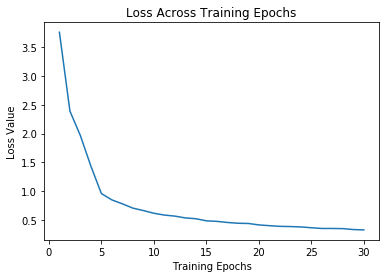

In [5]:
plt.plot(range(1,31), loss)
plt.title('Loss Across Training Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Loss Value')
plt.show()

In [42]:
raw[raw.str.contains('TEST : total')].tail(1).values[0]

'TEST : total : test_f1: 0.9061 test_rec: 0.9065 test_pre: 0.9057 test_acc: 0.9797 | '

In [64]:
################################################################################
ts = re.compile(r'TEST : (\w+).+(\d\.\d+).+?(\d\.\d+).+?(\d\.\d+).+(\d\.\d+)')
def getBestTestPerf(set):
    found = raw.str.contains('TEST : '+set) # pick all lines contain test info
    m = ts.match(raw[found].tail(1).values[0]) # get stats from last test line
    out =  {'type':m[1], 'f1':float(m[2]), 'rec':float(m[3]), 'prec':float(m[4])}
    #return (m[1], float(m[2]), float(m[3]), float(m[4]))
    return out

In [65]:
getBestTestPerf('total')

{'type': 'total', 'f1': 0.9061, 'rec': 0.9065, 'prec': 0.9057}

In [23]:
getTestPerf(s)

('I-ORG', 0.0221, 0.012, 0.1389)

In [62]:
s = "TEST : total : test_f1: 0.9061 test_rec: 0.9065 test_pre: 0.9057 test_acc: 0.9797 | "
ts.match(s)

<re.Match object; span=(0, 81), match='TEST : total : test_f1: 0.9061 test_rec: 0.9065 t>